## Doublet Removal - Pseudo Doublets

In [55]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# data files are in the filtered matrix folder from CellRanger which has been renamed to the sample name
sample_name = r'sc85_1g' #r'sc70_1' #r'sc72_1'
data_path = r"./raw_data/"
data_files_path = data_path + sample_name + r""

results_path = 'results/'
results_file = results_path + sample_name + '-db.h5ad'  # the file that will store the analysis results
metrics_file = results_path + sample_name + '_db_metrics.csv'  # the file that will store the metrics
# make results folder if it doesn't exist
if not os.path.exists(results_path):
    os.makedirs(results_path, exist_ok=False)

scanpy==1.10.3 anndata==0.11.0 umap==0.5.7 numpy==1.26.4 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


#### Setup R environment

In [56]:
import os
os.environ['R_HOME'] = r"C:\Program Files\R\R-4.4.2"  
import anndata2ri # order matters, comes after defining 'R_HOME
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%reload_ext rpy2.ipython

C:\Users\leeh1\AppData\Local\Temp\ipykernel_6804\364680306.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [57]:
%%R
.libPaths(c("C:/Users/leeh1/AppData/Local/R/win-library/4.4", .libPaths()))
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

#### Load data

Read in count data into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object.  
The matrix.mtx file contains a sparse matrix of the counts.  
Barcodes file contains the sample names in the format: AAACCCAAGACCATAA-1  
Features file contains the gene id in the format: ENSMUSG00000051951, Xkr4, Gene Expression

The number of counts per cell will be relatively low since only UMIs are counted by Cellranger

In [80]:
adata = sc.read_10x_mtx(
    data_files_path,              # the directory with the `.mtx` file
    var_names='gene_symbols',     # use gene symbols for the variable names (variables-axis index)
    cache=True)                   # write a cache file for faster subsequent reading

# adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
print('Data matrix is sparse:', scipy.sparse.issparse(adata.X))
print()

# make the obs names unique by adding the sample name
adata.obs_names = [g.split("-")[0] + '_' + sample_name for g in adata.obs_names]
print(adata.obs_names[0:2])
print()
print('Number of cells =', f"{adata.n_obs:,.0f}")
print('Number of genes =', f"{adata.n_vars:,.0f}")
print('Number of counts =', f"{adata.X.sum():,.0f}")
print('Mean counts per cell =', f"{adata.X.sum()/adata.n_obs:,.0f}")
adata

... reading from cache file cache\raw_data-sc85_1g-matrix.h5ad
Data matrix is sparse: True

Index(['AAACAGCCAACCGCCA_sc85_1g', 'AAACAGCCAAGGTATA_sc85_1g'], dtype='object')

Number of cells = 15,830
Number of genes = 36,530
Number of counts = 13,291,714
Mean counts per cell = 840


AnnData object with n_obs × n_vars = 15830 × 36530
    var: 'gene_ids', 'feature_types'

In [81]:
n_cells = adata.n_obs
n_genes = adata.n_vars
n_counts = adata.X.sum()    
counts_per_cell = round(n_counts / n_cells)

df_metrics = pd.DataFrame([n_cells, n_genes, n_counts, counts_per_cell], \
                  index = ['Number of cells', 'Number of genes', 'Number of counts','Mean counts per cell']).T
df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
df_metrics.index = [sample_name]
df_metrics

C:\Users\leeh1\AppData\Local\Temp\ipykernel_6804\1815972615.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_6804\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    36,530
Name: Number of genes, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].applymap('{:,.0f}'.format)
C:\Users\leeh1\AppData\Local\Temp\ipykernel_6804\1815972615.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0    13,291,714
Name: Number of counts, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_metrics.iloc[:, 1:] = df_metrics.iloc[:,1:].

,Number of cells,Number of genes,Number of counts,Mean counts per cell
sc85_1g,15830.0,"36,530","13,291,714",840


### Detect doublets
Remove "empty" genes before doublet detection.

In [82]:
sc.pp.filter_genes(adata, min_cells=1)
df_metrics['Filter genes:'] = ' '
df_metrics['Number of genes removed'] = n_genes - adata.n_vars

filtered out 11479 genes that are detected in less than 1 cells


In [83]:
data_mat = adata.X.T                 # transform data matrix
doublet_ratio = n_cells/1000*0.008   # calculate multiplet rate based on 10x formula
print('multiplet rate = %4.1f' %(doublet_ratio*100), '%')

multiplet rate = 12.7 %


In [84]:
%%R -i data_mat -i doublet_ratio -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(SingleCellExperiment(list(counts=data_mat),), dbr=doublet_ratio)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~12664 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 2878 cells excluded from training.
iter=1, 3021 cells excluded from training.
iter=2, 3031 cells excluded from training.
Threshold found:0.48
2666 (16.8%) doublets called


In [85]:
doublets = [1.0 if x == 'doublet' else 0 for x in doublet_class]
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs["doublet"] = doublets

In [86]:
doublet_percentage = sum(doublets)/adata.n_obs*100
print('Doublet percentage = %4.1f' %(doublet_percentage))
df_metrics['Doublet removal:'] = ' '
df_metrics['Doublet percentage'] =  doublet_percentage

adata.obs.scDblFinder_class.value_counts()

Doublet percentage = 16.8


scDblFinder_class
singlet    13164
doublet     2666
Name: count, dtype: int64

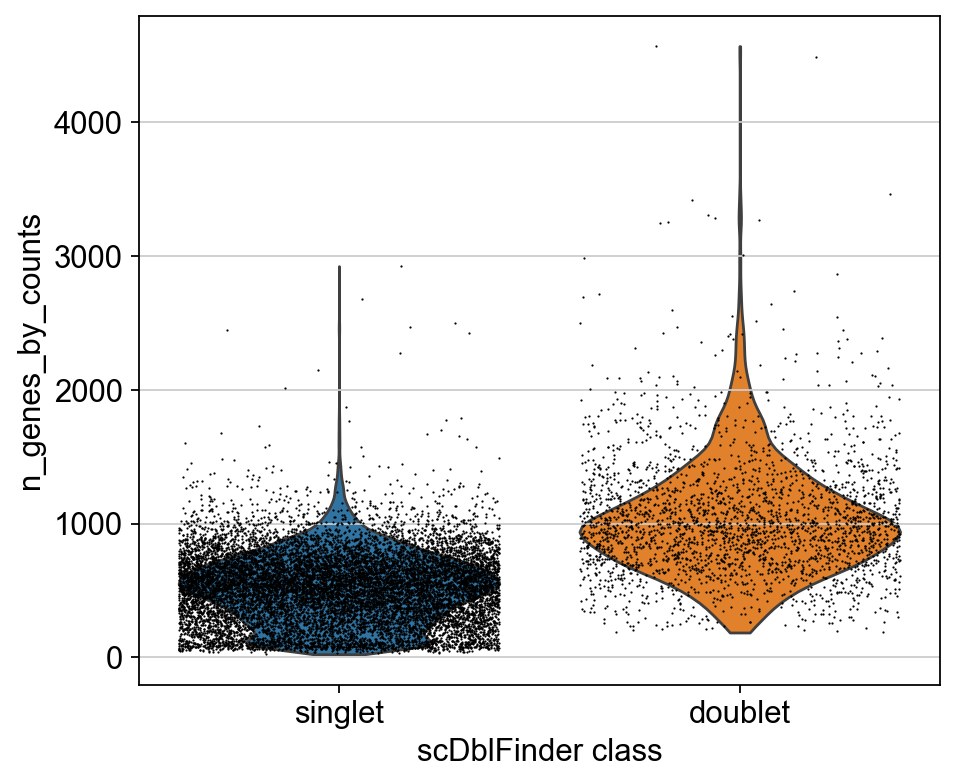

In [87]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'scDblFinder_class')

In [88]:
num_before = adata.n_obs
singlets = adata.obs["scDblFinder_class"] == 'singlet'
num_after = adata[singlets].n_obs
n_genes = adata[singlets].n_vars
n_counts = adata[singlets].X.sum()    
counts_per_cell = round(n_counts / n_cells)

print('Number of cells before doublet removal =', num_before)
print('Number of cells after doublet removal =', num_after)
print('Number of cells removed =', num_before - num_after)
removed_percentage = (num_before - num_after)/num_before*100
print('Percentage of cells removed = %4.1f' %(removed_percentage))
n_counts = adata.X.sum()  
print('Number of counts =', f"{n_counts:,.0f}")
print('Mean counts per cell =', f"{counts_per_cell:,.0f}")

df_metrics['Number of cells removed'] =  num_before - num_after
df_metrics['After doublet removal:'] = ' '
df_metrics['Number of cells -db'] = num_after
df_metrics['Number of genes -db'] = n_genes
df_metrics['Number of counts -db'] = n_counts
df_metrics['Mean counts per cell -db'] = counts_per_cell

Number of cells before doublet removal = 15830
Number of cells after doublet removal = 13164
Number of cells removed = 2666
Percentage of cells removed = 16.8
Number of counts = 13,291,714
Mean counts per cell = 585


In [89]:
adata[singlets].write(results_file)
# print(adata)

In [90]:
df_metrics.T.to_csv(metrics_file)

### Isolating Singlets

In [236]:
bdata = adata[singlets].copy()
print(bdata)

AnnData object with n_obs × n_vars = 13164 × 25051
    obs: 'scDblFinder_score', 'scDblFinder_class', 'doublet', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scDblFinder_class_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


### UMAP
Visualize the data before and after doublet removal.

In [92]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:13)


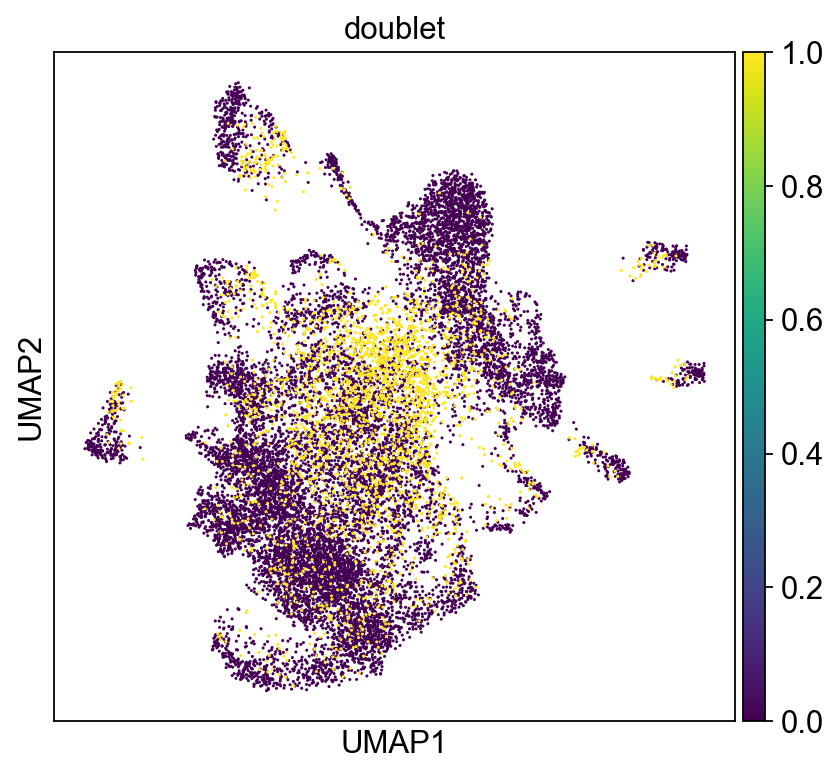

In [93]:
rcParams['figure.figsize'] = 6, 5.5
sc.pl.umap(adata, color=['doublet'])

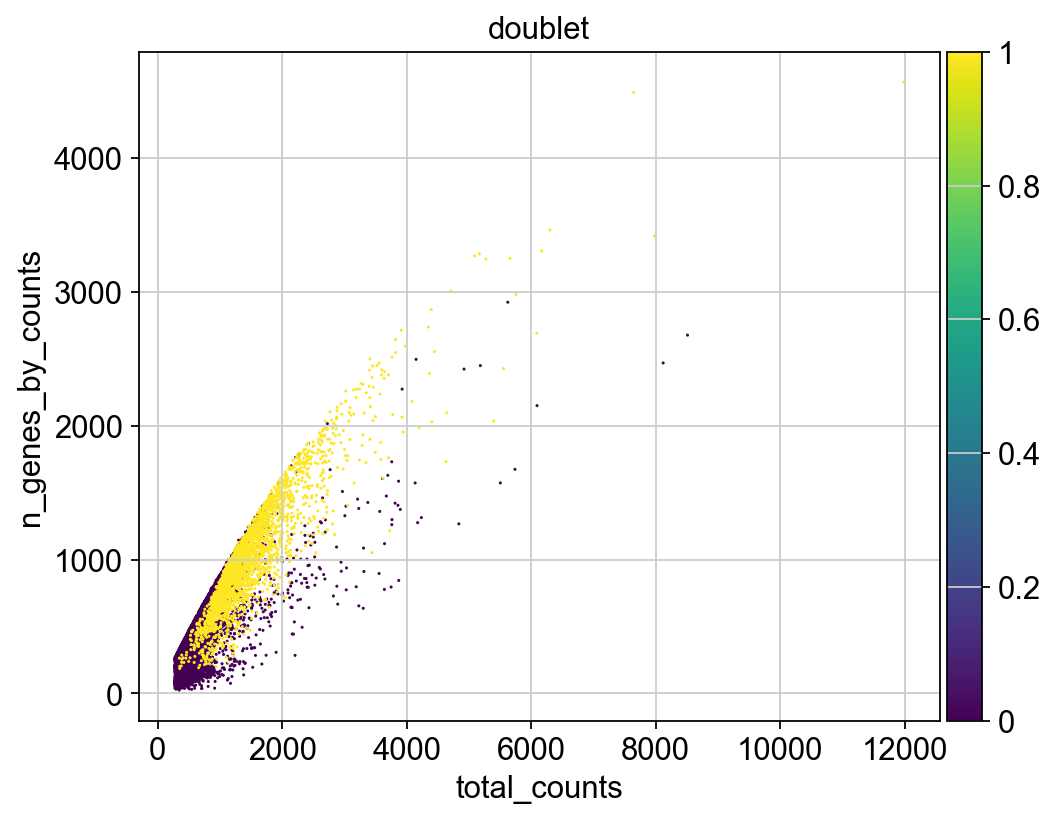

In [94]:
sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='doublet')

### Exporting Doublets to a `.txt` file
Printing out doublet subsets for future comparisons

In [237]:
adata_dbl = adata.obs["scDblFinder_class"] == 'doublet'
adata_dbl = adata.obs_names[adata_dbl]

In [238]:
print(adata_dbl)

Index(['AAACAGCCACCAGGTT_sc85_1g', 'AAACCGAAGTTTGGTA_sc85_1g',
       'AAACCGCGTAGGATCC_sc85_1g', 'AAACCGCGTGATGAAA_sc85_1g',
       'AAACCGCGTTTCGCCA_sc85_1g', 'AAACCGGCAAACATAG_sc85_1g',
       'AAACGCGCAGTATGTT_sc85_1g', 'AAACGGATCACTAAGC_sc85_1g',
       'AAACGGATCCCGTTAC_sc85_1g', 'AAACGGATCTCCATGC_sc85_1g',
       ...
       'TTTGGTAAGGTCTTGG_sc85_1g', 'TTTGGTGCACCTCAGG_sc85_1g',
       'TTTGGTGCATTGTGAT_sc85_1g', 'TTTGTCCCAAGTGTCC_sc85_1g',
       'TTTGTCTAGCTCCTAC_sc85_1g', 'TTTGTCTAGCTTAACA_sc85_1g',
       'TTTGTGAAGTGAGCAA_sc85_1g', 'TTTGTGGCACCGTTCC_sc85_1g',
       'TTTGTGGCACTTGTTC_sc85_1g', 'TTTGTGTTCCTAAGGT_sc85_1g'],
      dtype='object', length=2666)


In [239]:
with open("./results/scDblFinder_sc85_1g_ids.txt", "w") as txt_file:
    for cell in adata_dbl:
        txt_file.write(cell + "\n")

## Creating Pseudo Doublets

In [240]:
singlet_data = bdata.X.T
n_pseudo_doubs = int(0.1 * bdata.shape[0])
print("Number of pseudo_doublets to be generated: " + str(n_pseudo_doubs))

Number of pseudo_doublets to be generated: 1316


In [241]:
%%R -i singlet_data -i n_pseudo_doubs -o pseudo_doublets -o pd_count_matrix -o names

pseudo_doublets = getArtificialDoublets(
    x=singlet_data,   
    n=n_pseudo_doubs,  
    resamp=0.1, 
    propRandom=0,  
    selMode="proportional",  
    meta.triplets=FALSE  
)

pd_count_matrix <- pseudo_doublets$counts
str(pd_count_matrix)
names <- pd_count_matrix@Dimnames[[2]]
str(names)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:1198120] 51 75 92 158 180 182 189 194 200 216 ...
  ..@ p       : int [1:1317] 0 834 1923 2932 4016 4821 5877 6567 7665 8825 ...
  ..@ Dim     : int [1:2] 25051 1316
  ..@ Dimnames:List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:1316] "rDbl.1" "rDbl.2" "rDbl.3" "rDbl.4" ...
  ..@ x       : num [1:1198120] 0.491 0.491 0.355 0.355 1.118 ...
  ..@ factors : list()
 chr [1:1316] "rDbl.1" "rDbl.2" "rDbl.3" "rDbl.4" "rDbl.5" "rDbl.6" ...


In [242]:
print("pd_count_matrix shape:", pd_count_matrix)

pd_count_matrix shape: <Compressed Sparse Column sparse matrix of dtype 'float64'
	with 1198120 stored elements and shape (25051, 1316)>
  Coords	Values
  (51, 0)	0.4914310574531555
  (75, 0)	0.4914310574531555
  (92, 0)	0.3554992079734802
  (158, 0)	0.3554992079734802
  (180, 0)	1.1182475090026855
  (182, 0)	0.5611718893051147
  (189, 0)	0.3554992079734802
  (194, 0)	0.3554992079734802
  (200, 0)	0.3554992079734802
  (216, 0)	0.3554992079734802
  (227, 0)	0.3554992079734802
  (230, 0)	0.3554992079734802
  (257, 0)	0.3554992079734802
  (265, 0)	0.3554992079734802
  (278, 0)	0.3554992079734802
  (310, 0)	0.4914310574531555
  (315, 0)	0.8972344994544983
  (321, 0)	0.3554992079734802
  (336, 0)	0.5611718893051147
  (340, 0)	0.7344191670417786
  (355, 0)	0.3554992079734802
  (392, 0)	0.3554992079734802
  (426, 0)	0.3554992079734802
  (447, 0)	0.3554992079734802
  (476, 0)	0.4914310574531555
  :	:
  (24513, 1315)	0.2863698899745941
  (24536, 1315)	0.2863698899745941
  (24560, 1315)	0.396595

In [243]:
print("names", names)

names ['rDbl.1' 'rDbl.2' 'rDbl.3' ... 'rDbl.1314' 'rDbl.1315' 'rDbl.1316']


#### Cleaning up `bdata`

In [266]:
print(bdata.shape)
print(bdata.obs)
print(bdata.var_names)

(13164, 25051)
                          doublet
AAACAGCCAACCGCCA_sc85_1g      0.0
AAACAGCCAAGGTATA_sc85_1g      0.0
AAACAGCCAATAGCAA_sc85_1g      0.0
AAACAGCCATGAATCT_sc85_1g      0.0
AAACATGCAAGTGAAC_sc85_1g      0.0
...                           ...
TTTGTTGGTTAAGTGT_sc85_1g      0.0
TTTGTTGGTTACGCGG_sc85_1g      0.0
TTTGTTGGTTAGGATT_sc85_1g      0.0
TTTGTTGGTTGCCTCA_sc85_1g      0.0
TTTGTTGGTTGGCGTG_sc85_1g      0.0

[13164 rows x 1 columns]
Index(['LOC139071432', 'LOC107385520', 'LOC139072245', 'LOC139063175',
       'LOC139064302', 'LOC139072279', 'LOC129159217', 'LOC139071444',
       'LOC129160091', 'LOC107372990',
       ...
       'KEG92_t17', 'KEG92_t18', 'KEG92_t19', 'KEG92_p03', 'KEG92_p02',
       'KEG92_t20', 'KEG92_p01', 'KEG92_t21', 'KEG92_t22', 'KEG92_t23'],
      dtype='object', length=25051)


In [245]:
bdata.obs.drop(columns=["scDblFinder_score"], inplace=True)
bdata.obs.drop(columns=["scDblFinder_class"], inplace=True)
bdata.obs.drop(columns=["n_genes_by_counts"], inplace=True)
bdata.obs.drop(columns=["total_counts"], inplace=True)

print(bdata.obs)

                          doublet
AAACAGCCAACCGCCA_sc85_1g      0.0
AAACAGCCAAGGTATA_sc85_1g      0.0
AAACAGCCAATAGCAA_sc85_1g      0.0
AAACAGCCATGAATCT_sc85_1g      0.0
AAACATGCAAGTGAAC_sc85_1g      0.0
...                           ...
TTTGTTGGTTAAGTGT_sc85_1g      0.0
TTTGTTGGTTACGCGG_sc85_1g      0.0
TTTGTTGGTTAGGATT_sc85_1g      0.0
TTTGTTGGTTGCCTCA_sc85_1g      0.0
TTTGTTGGTTGGCGTG_sc85_1g      0.0

[13164 rows x 1 columns]


In [248]:
print(bdata.X)

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 6810735 stored elements and shape (13164, 25051)>
  Coords	Values
  (1213, 0)	0.7252199053764343
  (5403, 0)	0.5554749965667725
  (5451, 0)	0.4361676275730133
  (7302, 0)	0.5185462236404419
  (7455, 0)	0.6318713426589966
  (8931, 0)	0.7822877168655396
  (9437, 0)	0.5956829190254211
  (10390, 0)	0.5946680903434753
  (7157, 1)	0.55024254322052
  (9135, 2)	0.7530362606048584
  (9836, 3)	0.5997779965400696
  (12531, 4)	0.6267483234405518
  (15, 5)	0.8795453906059265
  (121, 5)	0.54007488489151
  (266, 5)	0.8615896105766296
  (547, 5)	0.7665108442306519
  (1019, 5)	0.7639459371566772
  (1137, 5)	0.8309487104415894
  (1315, 5)	0.6044548153877258
  (1587, 5)	0.9770779609680176
  (1748, 5)	0.6118811368942261
  (2196, 5)	0.6594695448875427
  (2797, 5)	0.4846401512622833
  (3024, 5)	0.608675479888916
  (3059, 5)	0.5847126245498657
  :	:
  (5446, 25050)	0.6748849153518677
  (5605, 25050)	0.5896471738815308
  (5634, 25050)	1.07418775

#### Creating `pseudo_doublet_adata`

In [267]:
import anndata
pseudo_doublet_adata = anndata.AnnData(pd_count_matrix)
pseudo_doublet_adata = pseudo_doublet_adata.T
pseudo_doublet_adata.obs_names = names
pseudo_doublet_adata.var_names = bdata.var_names
pseudo_doublet_adata.obs["doublet"] = 1.0

In [268]:
print(pseudo_doublet_adata.shape)
print(pseudo_doublet_adata.obs_names)
print(pseudo_doublet_adata.var_names)
print(pseudo_doublet_adata.obs)
print(pseudo_doublet_adata.X)

(1316, 25051)
Index(['rDbl.1', 'rDbl.2', 'rDbl.3', 'rDbl.4', 'rDbl.5', 'rDbl.6', 'rDbl.7',
       'rDbl.8', 'rDbl.9', 'rDbl.10',
       ...
       'rDbl.1307', 'rDbl.1308', 'rDbl.1309', 'rDbl.1310', 'rDbl.1311',
       'rDbl.1312', 'rDbl.1313', 'rDbl.1314', 'rDbl.1315', 'rDbl.1316'],
      dtype='object', length=1316)
Index(['LOC139071432', 'LOC107385520', 'LOC139072245', 'LOC139063175',
       'LOC139064302', 'LOC139072279', 'LOC129159217', 'LOC139071444',
       'LOC129160091', 'LOC107372990',
       ...
       'KEG92_t17', 'KEG92_t18', 'KEG92_t19', 'KEG92_p03', 'KEG92_p02',
       'KEG92_t20', 'KEG92_p01', 'KEG92_t21', 'KEG92_t22', 'KEG92_t23'],
      dtype='object', length=25051)
           doublet
rDbl.1         1.0
rDbl.2         1.0
rDbl.3         1.0
rDbl.4         1.0
rDbl.5         1.0
...            ...
rDbl.1312      1.0
rDbl.1313      1.0
rDbl.1314      1.0
rDbl.1315      1.0
rDbl.1316      1.0

[1316 rows x 1 columns]
<Compressed Sparse Row sparse matrix of dtype 'float64

#### Concatenating adata objects

In [269]:
adata_combined = anndata.concat([pseudo_doublet_adata, bdata], axis=0, join="inner")

In [270]:
print(adata_combined.shape)

(14480, 25051)


In [276]:
print(adata_combined.obs)
print(adata_combined.var)
print(adata_combined.X)

                          doublet
rDbl.1                        1.0
rDbl.2                        1.0
rDbl.3                        1.0
rDbl.4                        1.0
rDbl.5                        1.0
...                           ...
TTTGTTGGTTAAGTGT_sc85_1g      0.0
TTTGTTGGTTACGCGG_sc85_1g      0.0
TTTGTTGGTTAGGATT_sc85_1g      0.0
TTTGTTGGTTGCCTCA_sc85_1g      0.0
TTTGTTGGTTGGCGTG_sc85_1g      0.0

[14480 rows x 1 columns]
Empty DataFrame
Columns: []
Index: [LOC139071432, LOC107385520, LOC139072245, LOC139063175, LOC139064302, LOC139072279, LOC129159217, LOC139071444, LOC129160091, LOC107372990, LOC107374007, LOC107373397, LOC139061825, LOC139062201, acsl4a, nxt2, psmd10, xiap, stag2b, efnb1, LOC139063402, LOC139063644, LOC107378241, LOC107379485, zc4h2, LOC107380808, asb12b, LOC139066172, tenm1, LOC139066346, LOC139066357, sh2d1ab, LOC107389596, apool, si:ch211-26b3.4, hdx, rps6kal, LOC107383029, LOC139061497, LOC107397113, si:dkey-237j10.2, sh3bgrl, LOC107374700, LOC107374845,

In [277]:
adata_combined.write("pseudo_doublets_sc85_1g.h5ad")

### Exporting Pseudo Doublets

In [278]:
with open("./results/pseudo_sc85_1g_ids.txt", "w") as txt_file:
    for cell in names:
        txt_file.write(cell + "\n")